In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

Data Head:
                  exchange_rate
date                           
01-01-1990 00:00         0.7855
02-01-1990 00:00         0.7818
03-01-1990 00:00         0.7867
04-01-1990 00:00         0.7860
05-01-1990 00:00         0.7849

Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 7588 entries, 01-01-1990 00:00 to 10-10-2010 00:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   exchange_rate  7588 non-null   float64
dtypes: float64(1)
memory usage: 118.6+ KB
None


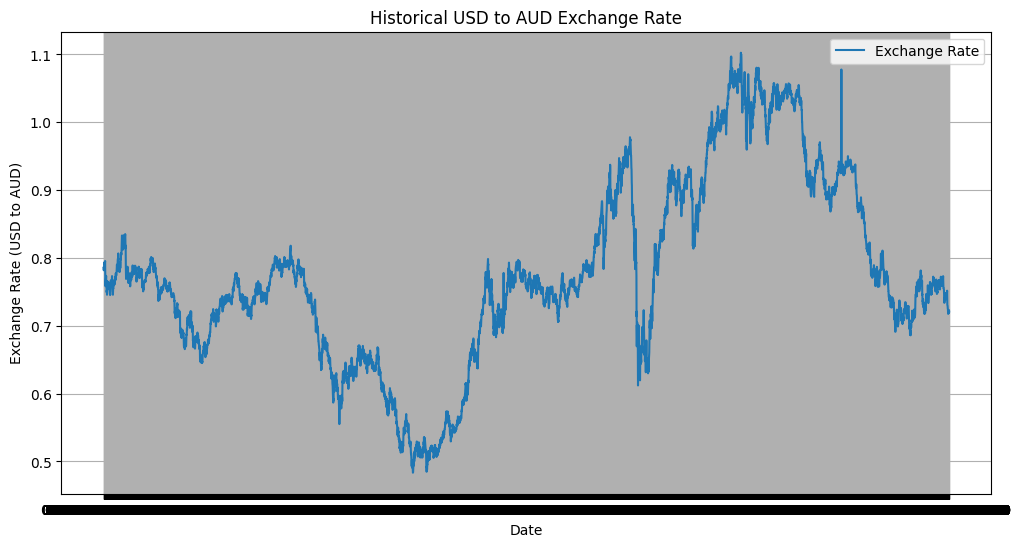

In [20]:
# Data Preparation and Exploration
# Data Preparation and Exploration

# 1. Data Loading
def data(filepath='/content/exchange_rate.csv'):
    """Load and preprocess the exchange rate data"""
    df = pd.read_csv('/content/exchange_rate.csv', parse_dates=['date'])
    df.set_index('date', inplace=True)
    df.columns = ['exchange_rate']  # Rename column for clarity
    return df

# Load the data
df = data('exchange_rate.csv')
print("Data Head:")
print(df.head())
print("\nData Info:")
print(df.info())

# 2. Initial Exploration
def plot_time_series(data, title):
    """Plot the time series data"""
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['exchange_rate'], label='Exchange Rate')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Exchange Rate (USD to AUD)')
    plt.legend()
    plt.grid(True)
    plt.show()
plot_time_series(df, 'Historical USD to AUD Exchange Rate')


In [21]:
# 3. Data Preprocessing
def check_stationarity(data):
    """Check stationarity using Augmented Dickey-Fuller test"""
    result = adfuller(df['exchange_rate'])
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

check_stationarity(df)

# Differencing to make data stationary
df['diff_1'] = df['exchange_rate'].diff()
df.dropna(inplace=True)
check_stationarity(df[['diff_1']])

ADF Statistic: -1.6649941807382342
p-value: 0.4492327353597477
Critical Values:
	1%: -3.4312123140180137
	5%: -2.861921078147796
	10%: -2.5669728434336108
ADF Statistic: -1.665359130276889
p-value: 0.4490430180299346
Critical Values:
	1%: -3.4312124277432754
	5%: -2.8619211283985426
	10%: -2.566972870182754


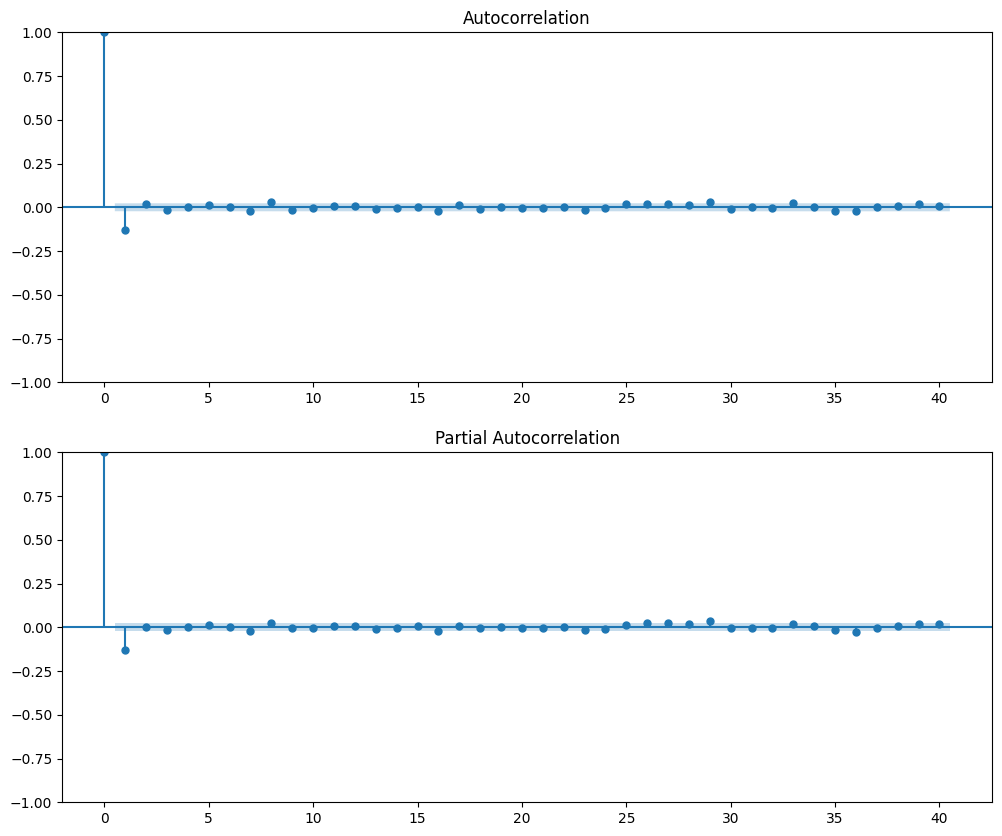

                               SARIMAX Results                                
Dep. Variable:          exchange_rate   No. Observations:                 7587
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28050.093
Date:                Wed, 26 Mar 2025   AIC                         -56094.186
Time:                        07:56:29   BIC                         -56073.384
Sample:                             0   HQIC                        -56087.047
                               - 7587                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1270      0.045     -2.801      0.005      -0.216      -0.038
ma.L1         -0.0044      0.045     -0.097      0.923      -0.094       0.085
sigma2      3.596e-05   9.95e-08    361.568      0.0

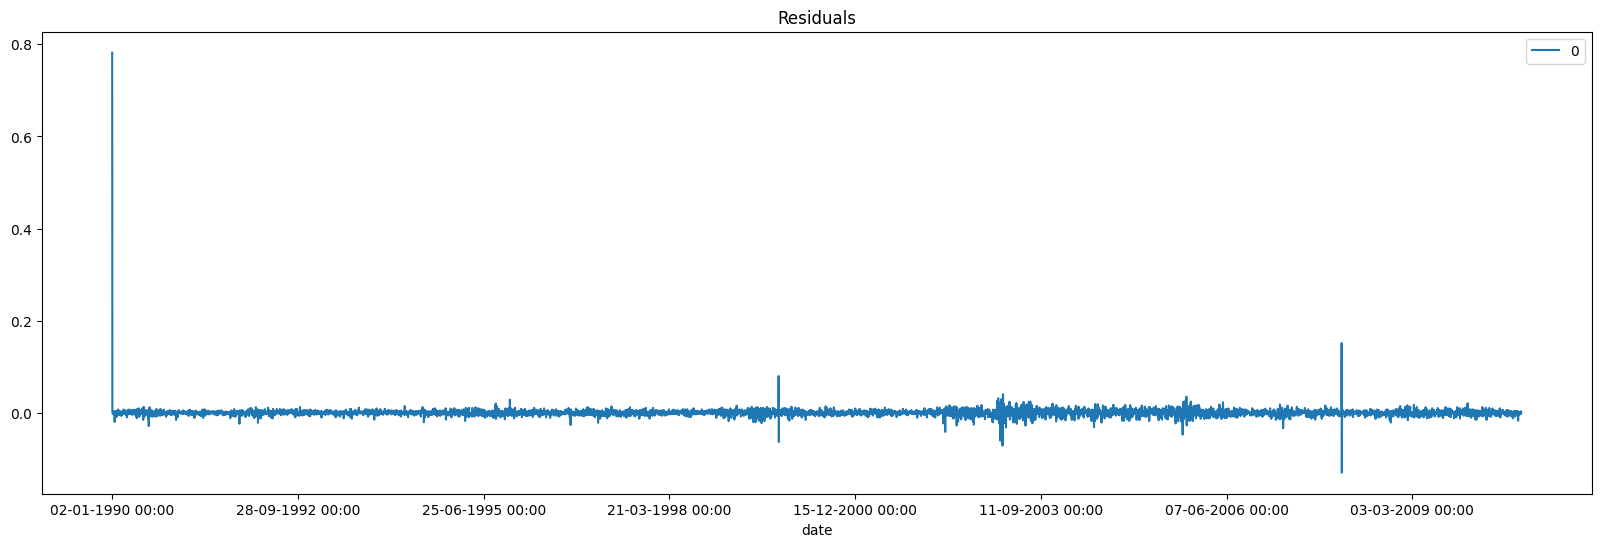

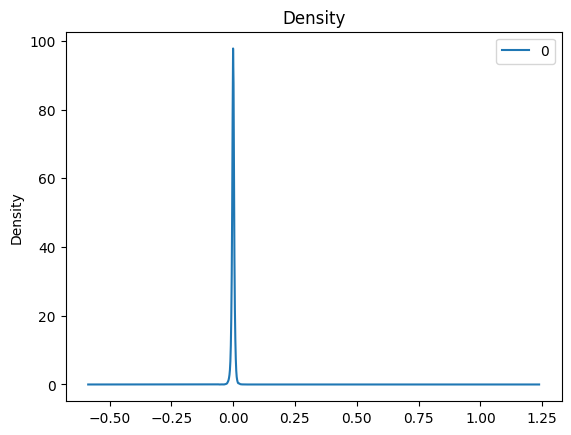

In [43]:
# Model Building - ARIMA

# 1. Parameter Selection for ARIMA
def plot_acf_pacf(data):
    """Plot ACF and PACF to determine ARIMA parameters"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    plot_acf(data, lags=40, ax=ax1)
    plot_pacf(data, lags=40, ax=ax2)
    plt.show()

plot_acf_pacf(df['diff_1'])

# Based on ACF/PACF, we'll try ARIMA(1,1,1) as initial model
p, d, q = 1, 1, 1

# 2. Model Fitting
def fit_arima(data, order):
    """Fit ARIMA model to the data"""
    model = ARIMA(data['exchange_rate'], order=order)
    model_fit = model.fit()
    print(model_fit.summary())
    return model_fit

arima_model = fit_arima(df, (p, d, q))

 #3. Diagnostics
def plot_residuals(model_fit):
    """Plot residuals to check for patterns"""
    residuals = pd.DataFrame(model_fit.resid)
    plt.figure(figsize=(20, 6))
    residuals.plot(title="Residuals", ax=plt.gca())
    plt.show()
    residuals.plot(kind='kde', title='Density')
    plt.show()

plot_residuals(arima_model)

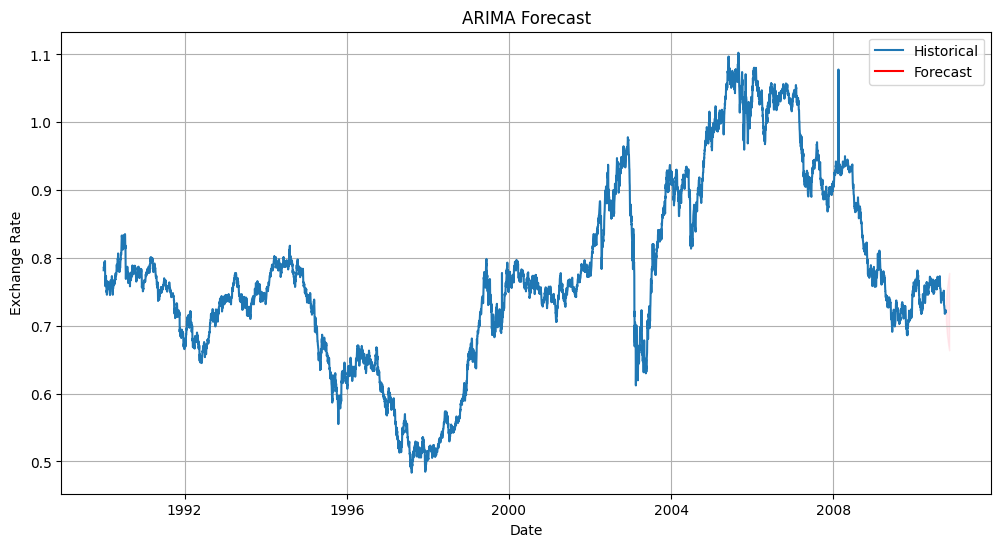

In [49]:
# 4. Forecasting
def arima_forecast(model_fit, steps, data):
    """Generate and plot ARIMA forecast"""
    forecast = model_fit.get_forecast(steps=steps)
    forecast_index = pd.date_range(data.index[-1], periods=steps+1, freq='D')[1:]
    forecast_df = pd.DataFrame(forecast.predicted_mean, index=forecast_index, columns=['forecast'])
    forecast_df.index = pd.to_datetime(forecast_df.index)
    data.index = pd.to_datetime(data.index, format='%d-%m-%Y %H:%M')

    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['exchange_rate'], label='Historical')
    plt.plot(forecast_df.index, forecast_df['forecast'], label='Forecast', color='red')
    plt.fill_between(forecast_df.index,
                    forecast.conf_int()['lower exchange_rate'],
                    forecast.conf_int()['upper exchange_rate'],
                    color='pink', alpha=0.3)
    plt.title('ARIMA Forecast')
    plt.xlabel('Date')
    plt.ylabel('Exchange Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

    return forecast_df
# Forecast next 30 days
arima_forecast_df = arima_forecast(arima_model, 30, df)

                       ExponentialSmoothing Model Results                       
Dep. Variable:            exchange_rate   No. Observations:                 7587
Model:             ExponentialSmoothing   SSE                              0.273
Optimized:                         True   AIC                         -77613.645
Trend:                         Additive   BIC                         -77502.698
Seasonal:                      Additive   AICC                        -77613.555
Seasonal Periods:                    12   Date:                 Wed, 26 Mar 2025
Box-Cox:                          False   Time:                         08:15:34
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.8698878                alpha                 True
smoothing_trend          

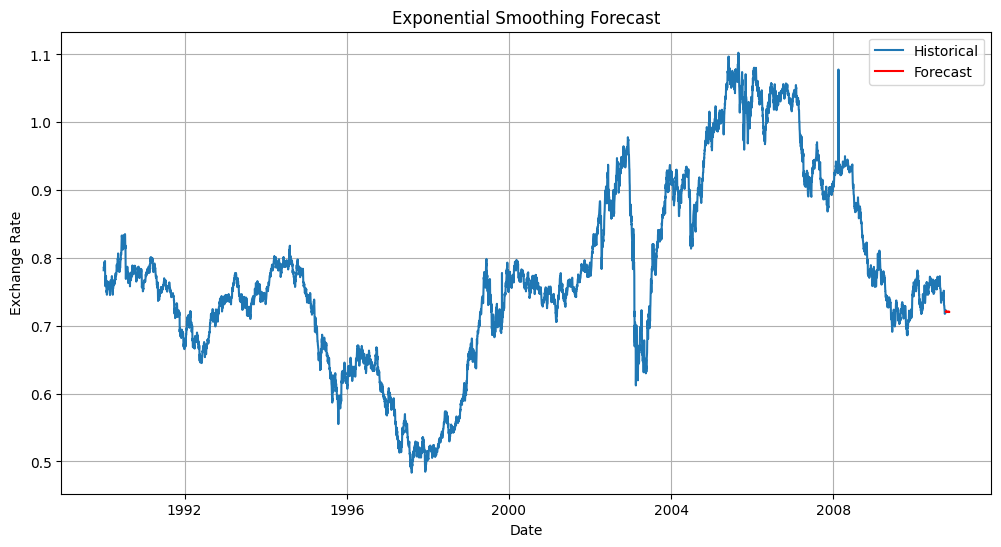

In [56]:
# Model Building - Exponential Smoothing

# 1. Model Selection - Using Holt-Winters as we might have seasonality
def fit_exponential_smoothing(data):
    """Fit Exponential Smoothing model"""
    model = ExponentialSmoothing(data['exchange_rate'],
                                trend='add',
                                seasonal='add',
                                seasonal_periods=12)
    model_fit = model.fit()
    print(model_fit.summary())
    return model_fit

ets_model = fit_exponential_smoothing(df)

# 2. Forecasting with ETS
def ets_forecast(model_fit, steps, data):
    """Generate and plot ETS forecast"""
    forecast = model_fit.forecast(steps)
    forecast_index = pd.date_range(data.index[-1], periods=steps+1, freq='D')[1:]
    forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=['forecast'])

    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['exchange_rate'], label='Historical')
    plt.plot(forecast_df.index, forecast_df['forecast'], label='Forecast', color='red')
    plt.title('Exponential Smoothing Forecast')
    plt.xlabel('Date')
    plt.ylabel('Exchange Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

    return forecast_df

# Forecast next 30 days
ets_forecast_df = ets_forecast(ets_model, 30, df)

In [60]:
# Evaluation and Comparison

# Split data into train and test sets
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Fit models on training data
arima_train_model = fit_arima(train, (1, 1, 1))
ets_train_model = fit_exponential_smoothing(train)

# Generate forecasts for test period
arima_test_forecast = arima_train_model.get_forecast(len(test))
ets_test_forecast = ets_train_model.forecast(len(test))

# Calculate error metrics
def calculate_metrics(actual, predicted):
    """Calculate MAE, RMSE, and MAPE"""
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mae, rmse, mape

arima_mae, arima_rmse, arima_mape = calculate_metrics(test['exchange_rate'], arima_test_forecast.predicted_mean)
ets_mae, ets_rmse, ets_mape = calculate_metrics(test['exchange_rate'], ets_test_forecast)

# Create comparison table
metrics_df = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'MAPE (%)'],
    'ARIMA': [arima_mae, arima_rmse, arima_mape],
    'Exponential Smoothing': [ets_mae, ets_rmse, ets_mape]
})

print("\nModel Comparison:")
print(metrics_df)


                               SARIMAX Results                                
Dep. Variable:          exchange_rate   No. Observations:                 6069
Model:                 ARIMA(1, 1, 1)   Log Likelihood               22714.982
Date:                Wed, 26 Mar 2025   AIC                         -45423.963
Time:                        08:20:17   BIC                         -45403.831
Sample:                    01-02-1990   HQIC                        -45416.976
                         - 08-14-2006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5979      0.062     -9.675      0.000      -0.719      -0.477
ma.L1          0.5405      0.064      8.453      0.000       0.415       0.666
sigma2      3.281e-05   1.95e-07    168.185      0.0

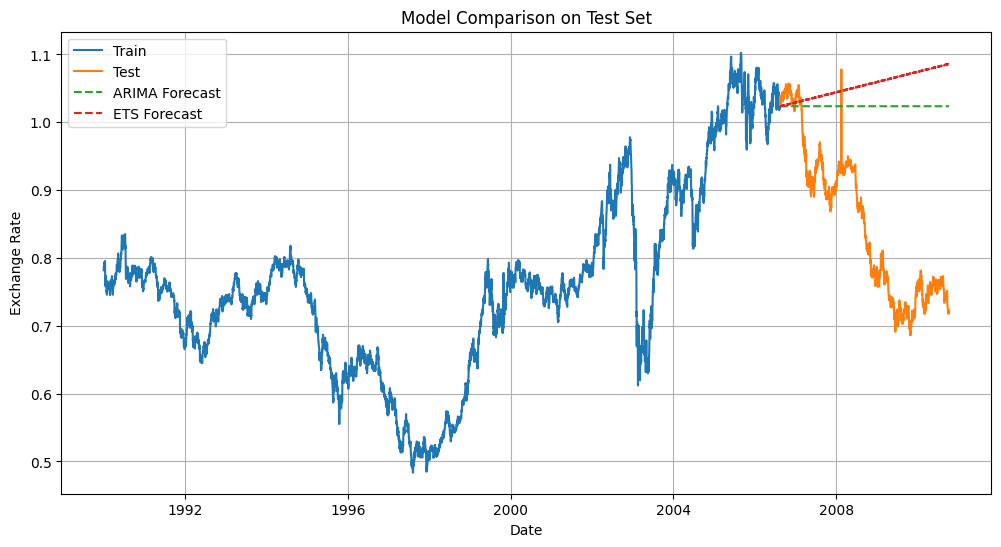


Conclusion:
Based on the error metrics, we can compare the performance of the two models.
Lower values of MAE, RMSE, and MAPE indicate better performance.
From the results, we can see which model performed better for this dataset.


In [62]:
# Plot comparison of forecasts
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['exchange_rate'], label='Train')
plt.plot(test.index, test['exchange_rate'], label='Test')
plt.plot(test.index, arima_test_forecast.predicted_mean, label='ARIMA Forecast', linestyle='--')
plt.plot(test.index, ets_test_forecast, label='ETS Forecast', linestyle='--')
plt.title('Model Comparison on Test Set')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

# Conclusion
print("\nConclusion:")
print("Based on the error metrics, we can compare the performance of the two models.")
print("Lower values of MAE, RMSE, and MAPE indicate better performance.")
print("From the results, we can see which model performed better for this dataset.")